# Overview
This Jupyter Notebook serves as our prototype of projection and reprojection functions. Codes in it should be executed in a specific order and conditions with a cooperation of our 2D segmentation codes. Basically, this notebook will load a model, take 4 rgbd views for it and export them to images to be passed into the 2D segmentation model. Then, after the 2D segmentation finishes, we read the segmentation masks and reproject them back into 3D to form a point cloud.

In [1]:
import numpy as np 
import os
import open3d as o3d
import matplotlib.pyplot as plt
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


## Function Definition
Here we have some function definition and packaging to use with Open3D.

In [2]:
def read_mesh(filename:str):
    #pcd = o3d.io.read_triangle_mesh(filename, True)
    pcd = o3d.io.read_triangle_model(filename, True)
    return pcd

In [3]:
def render(geometries):
    o3d.visualization.draw_geometries(geometries)

In [4]:
# side effect: will set renderer_pc's extrinsic camera
def get_view(renderer_pc, intrinsic, model, center, eye, extrinsic=None, img_width=400, img_height=500):


    # grey = o3d.visualization.rendering.MaterialRecord()
    # grey.base_color = [0.7, 0.7, 0.7, 1.0]
    # grey.shader = "defaultLit"
    
    # material = o3d.visualization.rendering.MaterialRecord()
    # texture = np.asarray(model.textures[0]).copy()
    # texture = o3d.geometry.Image(texture)
    # material.albedo_img = texture
    # material.aspect_ratio = 1.0
    # material.shader = "defaultLit"
    
    renderer_pc.scene.scene.set_sun_light([-1, -1, -1], [1.0, 1.0, 1.0], 100000)
    renderer_pc.scene.scene.enable_sun_light(True)

    #renderer_pc.scene.add_geometry("pcd", model, material)
    
    renderer_pc.scene.add_model("model", model)

    # Optionally set the camera field of view (to zoom in a bit)
    vertical_field_of_view = 15.0  # between 5 and 90 degrees
    aspect_ratio = img_width / img_height  # azimuth over elevation
    near_plane = 0.1
    far_plane = 50.0
    fov_type = o3d.visualization.rendering.Camera.FovType.Vertical
    #renderer_pc.scene.camera.set_projection(vertical_field_of_view, aspect_ratio, near_plane, far_plane, fov_type)
    renderer_pc.scene.camera.set_projection(intrinsic.intrinsic_matrix, near_plane, far_plane, img_width, img_height)

    # Look at the origin from the front (along the -Z direction, into the screen), with Y as Up.
    up = [0, 1, 0]  # camera orientation
    # extrinsic = lookat(np.asarray(center), np.asarray(eye), np.asarray(up))
    renderer_pc.scene.camera.look_at(center, eye, up)
    if extrinsic is not None:
        renderer_pc.setup_camera(intrinsic, extrinsic)
    # renderer_pc.setup_camera(intrinsic, extrinsic)

    depth_image = np.asarray(renderer_pc.render_to_depth_image(True) )
    image = np.asarray(renderer_pc.render_to_image())


    # plt.imshow(depth_image)
    renderer_pc.scene.remove_geometry("model")
    return (image, depth_image, renderer_pc.scene.camera.get_view_matrix())

In [5]:
def lookat(center, eye, up):
    f = (eye - center)
    f /= np.linalg.norm(f)
    
    r = np.cross(up, f)
    r /= np.linalg.norm(r)
    
    u = np.cross(f, r)
    u /= np.linalg.norm(u)

    view_matrix = np.eye(4)
    view_matrix[:3, :3] = np.column_stack((r, u, -f))
    view_matrix[:3, 3] = -np.dot(np.column_stack((r, u, -f)), eye)
    
    return view_matrix

In [ ]:
def flip(matrix):
    result = np.copy(matrix)
    result[1:3,:] = -1 * result[1:3,:]
    return result

In [6]:
def rgbd_to_pointcloud(rgbd, intrinsic, extrinsic_camera):
    # extrinsic_camera = np.array(extrinsic_camera)
    # extrinsic_camera = np.linalg.inv(extrinsic_camera)
    pcd =  o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic, flip(extrinsic_camera))
    # Flip it, otherwise the pointcloud will be upside down
    #pcd.transform([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    return pcd
def downsample_rescale(pcd, voxel_size=0.00001, scale=10000):
    downsampled_pc = pcd.voxel_down_sample(voxel_size)
    # use mean as the center for now
    a1 = np.asarray(downsampled_pc.points)
    scaled_downsampled_pc = downsampled_pc.scale(scale, a1.mean(0))
    return scaled_downsampled_pc

In [7]:
def downsample(pcd, voxel_size=0.00001):
    downsampled_pc = pcd.voxel_down_sample(voxel_size)
    return downsampled_pc

In [220]:
def read_segmentation(file_name, depth):
    # for read npy files
    rgb = np.load(file_name).astype(np.uint8)
    rgb = o3d.geometry.Image(rgb)
    ## for read image files
    #rgb = o3d.io.read_image(file_name)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgb, o3d.geometry.Image(depth), convert_rgb_to_intensity=False, depth_scale=1)
    return rgbd_image

## Renderer Initialization and Model Loading

In this part, we initialize a headless renderer of Open3d, define the resolution of images and the intrinsic camera matrix that will share among all cameras. Headless rendering has a different API with the Visualization(see reference: https://stackoverflow.com/questions/69696354/capture-depth-image-without-opening-visualizer-in-open3d). The resolution of images will affect the sampling resolution of the point cloud we create. A specific model is also loaded here. If you want to load another model, the parameter in read_mesh should be the path to your mesh.

In [10]:
img_width, img_height = (400, 500)
renderer_pc = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)
model = read_mesh("THuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0274/0274.obj")
intrinsic =  o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)




[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7ff678983010 (threading is enabled)
EGL(1.5)
OpenGL(4.2)
Reading model fileTHuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0274/0274.obj[========================================] 100%
Reading model fileTHuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0274/0274.obj[========================================] 100%


In [52]:
model = read_mesh("THuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0047/0047.obj")


Reading model fileTHuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0047/0047.obj[========================================] 100%
Reading model fileTHuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0047/0047.obj[========================================] 100%


## Projection
The main part for projection. Given a center and an eye position, get_view will return the RGB image and the depth image from that view built by the lookAt function. Extrinsic matrice are also returned and will be used to recontruct point clouds. Here in the prototype, we only use four fixed views. Actually, from our experiment, side views are always not reliable and more views are not necessarily better due to the matching problem.

The RGB images are saved as files and passed to the 2D segmentation pipeline.

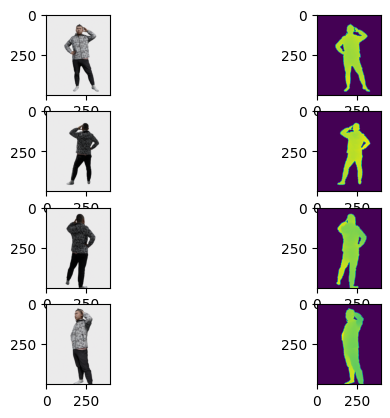

In [53]:
image1, depth1, extrinsic1 = get_view(renderer_pc, intrinsic, model, center=[0.25,0,0], eye=[0, 0, 1.25])
image2, depth2, extrinsic2 = get_view(renderer_pc, intrinsic, model, center=[-0.25,0,0], eye=[0.5, 0, -1.25])
image3, depth3, extrinsic3 = get_view(renderer_pc, intrinsic, model, center=[-0.25,0,0], eye=[-0.5, 0, -1])
image4, depth4, extrinsic4 = get_view(renderer_pc, intrinsic, model, center=[0.25,0,0], eye=[0.75, 0, 0.75])

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(image1), o3d.geometry.Image(depth1), convert_rgb_to_intensity=False, depth_scale=1)
rgbd_image2 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(image2), o3d.geometry.Image(depth2), convert_rgb_to_intensity=False, depth_scale=1)
rgbd_image3 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(image3), o3d.geometry.Image(depth3), convert_rgb_to_intensity=False, depth_scale=1)
rgbd_image4 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(image4), o3d.geometry.Image(depth4), convert_rgb_to_intensity=False, depth_scale=1)

plt.subplot(4, 2, 1)
plt.imshow(rgbd_image1.color)
plt.subplot(4, 2, 2)
plt.imshow(rgbd_image1.depth)
plt.subplot(4, 2, 3)
plt.imshow(rgbd_image2.color)
plt.subplot(4, 2, 4)
plt.imshow(rgbd_image2.depth)
plt.subplot(4, 2, 5)
plt.imshow(rgbd_image3.color)
plt.subplot(4, 2, 6)
plt.imshow(rgbd_image3.depth)
plt.subplot(4, 2, 7)
plt.imshow(rgbd_image4.color)
plt.subplot(4, 2, 8)
plt.imshow(rgbd_image4.depth)
plt.show()

In [55]:
plt.imsave("0047_image1.png", image1)
plt.imsave("0047_image2.png", image2)
plt.imsave("0047_image3.png", image3)
plt.imsave("0047_image4.png", image4)



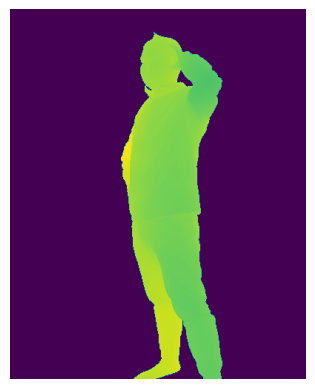

In [72]:
plt.axis("off")
plt.imshow(rgbd_image4.depth)
plt.savefig("0047_depth4.jpg")

## Reconstruction and Merging

In this part, we read segmentation masks from the output of the 2D segmentation pipeline. Instead of files, numpy arrays are prefered because the quantization of image file formats will break labels. Then, point clouds will be reconstruct for each of the views and merged into the final result. The render function will open a new window for visualization.

In [216]:
rgbd_image_seg1 = read_segmentation("/home/demoy/3dProjection/0047_image1_segmask.npy", depth1)
rgbd_image_seg2 = read_segmentation("/home/demoy/3dProjection/0047_image2_segmask.npy", depth2)
rgbd_image_seg3 = read_segmentation("/home/demoy/3dProjection/0047_image3_segmask.npy", depth3)
rgbd_image_seg4 = read_segmentation("/home/demoy/3dProjection/0047_image4_segmask.npy", depth4)

In [217]:
pcd1 = rgbd_to_pointcloud(rgbd_image_seg1, intrinsic, extrinsic1)
pcd2 = rgbd_to_pointcloud(rgbd_image_seg2, intrinsic, extrinsic2)
pcd3 = rgbd_to_pointcloud(rgbd_image_seg3, intrinsic, extrinsic3)
pcd4 = rgbd_to_pointcloud(rgbd_image_seg4, intrinsic, extrinsic4)

In [219]:
render([ pcd1, pcd3, pcd2, pcd4])

In [210]:
t = pcd1+pcd2+pcd3+pcd4
points = np.asarray(t.points)
colors = np.asarray(t.colors)

In [213]:
points.size

238998

In [197]:
# find replicate points
unique_rows, indice = np.unique(points, axis=0, return_index=True)
print(unique_rows.shape)

(152118, 3)


In [209]:
np.array(pcd1.points).size + np.array(pcd2.points).size + np.array(pcd3.points).size + np.array(pcd4.points).size

238998